# California Property Price Prediction

## Data Dictionary

| Variable             | Description                           | Type    | Unit    |
|----------------------|---------------------------------------|---------|---------|
| longitude            | Longitude of the property             | FLOAT   | degrees |
| latitude             | Latitude of the property              | FLOAT   | degrees |
| housing_median_age   | Median age of the houses               | INT     | years   |
| total_rooms          | Total number of rooms                  | INT     | count   |
| total_bedrooms       | Total number of bedrooms               | INT     | count   |
| population           | Population in the area                 | INT     | count   |
| households           | Number of households                   | INT     | count   |
| median_income        | Median income in the area              | FLOAT   | -       |
| median_house_value   | Median house value                     | FLOAT   | -       |
| ocean_proximity      | Proximity to the ocean                 | STRING  | -       |

---

In [2]:
# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

sns.set(style='whitegrid')


In [9]:
# 2. Load and Explore Dataset
#Absolutepath
df = pd.read_excel(r"D:\Internships\Internshala\Training Project\Part A Property Price Prediction\Data_file_1.xlsx")

print(df.head())
print(df.describe(include="all"))
print("Missing values per column:\n", df.isnull().sum())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                  41          880           129.0   
1    -122.22     37.86                  21         7099          1106.0   
2    -122.24     37.85                  52         1467           190.0   
3    -122.25     37.85                  52         1274           235.0   
4    -122.25     37.85                  52         1627           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0         322         126         8.3252              452600        NEAR BAY  
1        2401        1138         8.3014              358500        NEAR BAY  
2         496         177         7.2574              352100        NEAR BAY  
3         558         219         5.6431              341300        NEAR BAY  
4         565         259         3.8462              342200        NEAR BAY  
           longitude      latitude  housing_median_age   total_rooms  \
cou

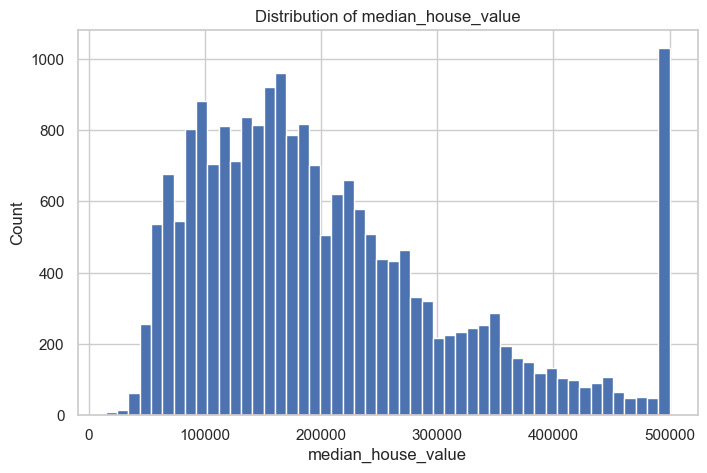

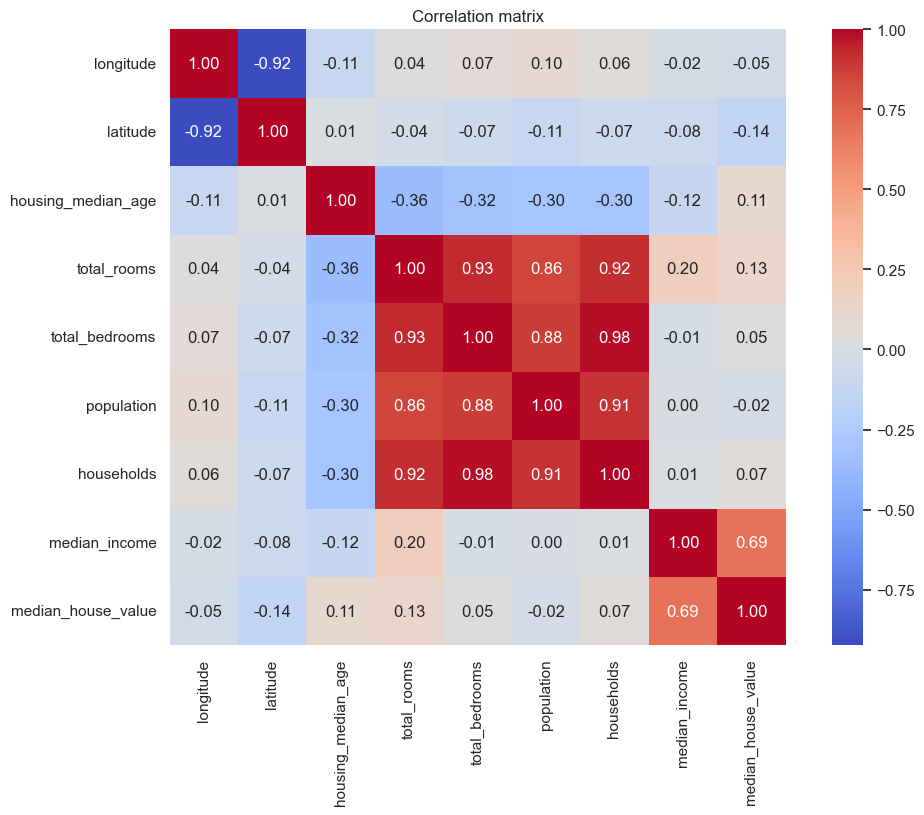

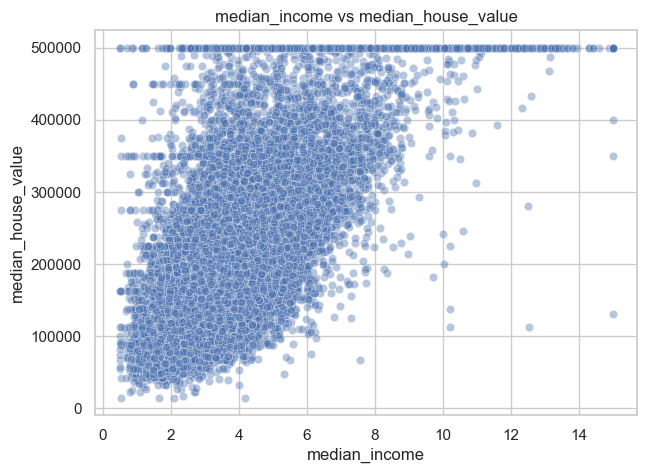

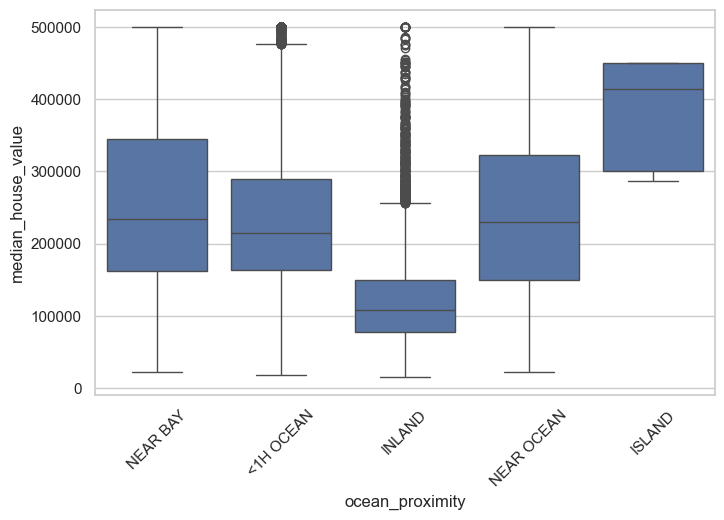

In [4]:
# 3. Exploratory Data Analysis (EDA)
TARGET = 'median_house_value'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Histogram
plt.figure(figsize=(8,5))
plt.hist(df[TARGET], bins=50)
plt.title('Distribution of ' + TARGET)
plt.xlabel(TARGET)
plt.ylabel('Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation matrix')
plt.show()

# Scatter: median_income vs target
if 'median_income' in df.columns:
    plt.figure(figsize=(7,5))
    sns.scatterplot(x='median_income', y=TARGET, data=df, alpha=0.4)
    plt.title('median_income vs ' + TARGET)
    plt.show()

# Boxplot: ocean_proximity vs target
if 'ocean_proximity' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='ocean_proximity', y=TARGET, data=df)
    plt.xticks(rotation=45)
    plt.show()


In [5]:
# 4. Data Preprocessing
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [c for c in numeric_cols if c != TARGET]

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, [c for c in X_train.columns if c in num_cols]),
    ('cat', categorical_transformer, [c for c in X_train.columns if c in cat_cols])
])


Simple Linear Regression:
MSE: 7091157771.77
RMSE: 84209.01
R²: 0.4589


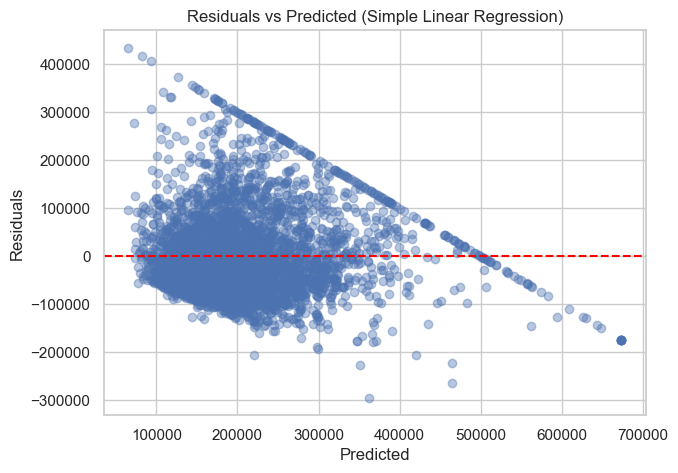

In [6]:
# 5. Simple Linear Regression
single_feature = 'median_income' if 'median_income' in X_train.columns else num_cols[0]

simple_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

simple_pipeline.fit(X_train[[single_feature]], y_train)
y_pred_simple = simple_pipeline.predict(X_test[[single_feature]])

mse_simple = mean_squared_error(y_test, y_pred_simple)
rmse_simple = np.sqrt(mse_simple)
r2_simple = r2_score(y_test, y_pred_simple)

print("Simple Linear Regression:")
print(f"MSE: {mse_simple:.2f}")
print(f"RMSE: {rmse_simple:.2f}")
print(f"R²: {r2_simple:.4f}")

# Residual plot
plt.figure(figsize=(7,5))
plt.scatter(y_pred_simple, y_test - y_pred_simple, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Simple Linear Regression)')
plt.show()


Multiple Linear Regression:
MSE: 4908290571.35
RMSE: 70059.19
R²: 0.6254


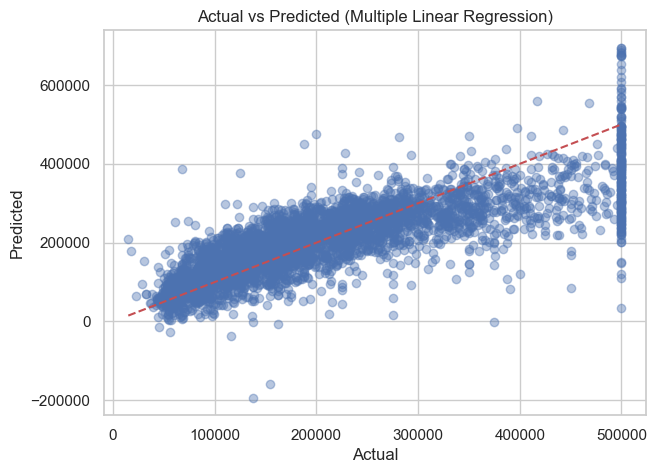

In [7]:
# 6. Multiple Linear Regression
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

full_pipeline.fit(X_train, y_train)
y_pred_full = full_pipeline.predict(X_test)

mse_full = mean_squared_error(y_test, y_pred_full)
rmse_full = np.sqrt(mse_full)
r2_full = r2_score(y_test, y_pred_full)

print("Multiple Linear Regression:")
print(f"MSE: {mse_full:.2f}")
print(f"RMSE: {rmse_full:.2f}")
print(f"R²: {r2_full:.4f}")

# Actual vs Predicted plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_full, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Multiple Linear Regression)')
plt.show()


In [8]:
# 7. Final Model Comparison & Success Criteria Evaluation
comparison_df = pd.DataFrame({
    "Model": ["Simple Linear Regression", "Multiple Linear Regression"],
    "MSE": [mse_simple, mse_full],
    "RMSE": [rmse_simple, rmse_full],
    "R²": [r2_simple, r2_full]
})

print("Model Performance Comparison:\n")
print(comparison_df.to_string(index=False))

print("\nObservations:")
print("- Multiple Linear Regression achieves lower MSE/RMSE and higher R² than Simple Linear Regression.")
print("- Simple Linear Regression is more interpretable (1 feature) but less accurate.")
print("- Multiple Linear Regression remains interpretable and offers higher accuracy.")
print("\nModel Choice: Multiple Linear Regression")
print("Reason: Balances accuracy and interpretability, fulfilling the success criteria.")

print("\nSuccess Criteria Check:")
print(" High degree of accuracy — Achieved with Multiple Linear Regression’s improved R² and reduced RMSE.")
print(" Interpretability — Both models are interpretable; MLR chosen for its accuracy + explainability.")
print(" Evaluation metrics (MSE, RMSE, R²) — Reported for both models.")
print(" Documentation & visualizations — EDA plots and performance plots included with explanations.")


Model Performance Comparison:

                     Model          MSE         RMSE       R²
  Simple Linear Regression 7.091158e+09 84209.012414 0.458859
Multiple Linear Regression 4.908291e+09 70059.193339 0.625438

Observations:
- Multiple Linear Regression achieves lower MSE/RMSE and higher R² than Simple Linear Regression.
- Simple Linear Regression is more interpretable (1 feature) but less accurate.
- Multiple Linear Regression remains interpretable and offers higher accuracy.

Model Choice: Multiple Linear Regression
Reason: Balances accuracy and interpretability, fulfilling the success criteria.

Success Criteria Check:
 High degree of accuracy — Achieved with Multiple Linear Regression’s improved R² and reduced RMSE.
 Interpretability — Both models are interpretable; MLR chosen for its accuracy + explainability.
 Evaluation metrics (MSE, RMSE, R²) — Reported for both models.
 Documentation & visualizations — EDA plots and performance plots included with explanations.


# Note on Hyperparameter Tuning

In this project, hyperparameter tuning was not applied because:

- Simple and Multiple Linear Regression models do not have tunable hyperparameters in the same sense as tree-based or regularized models.
- The main factors affecting performance are:
  - Selection of features
  - Data preprocessing (handling missing values, scaling, encoding)
- These steps were already implemented in the preprocessing pipeline.



In [ ]:
# Project Takeaways

#  Key Insights
-> Median income is the most significant predictor of house value in California districts.  
-> Including multiple features improves prediction accuracy compared to using a single feature.

---

# Business Impact
By using the multiple regression model, real estate analysts and policy makers can:
->More accurately estimate property prices.
->Identify the factors that most influence house values.
->Make informed decisions on urban planning and housing policy.

---

*One Final Note:
The final multiple linear regression model balances accuracy and interpretability, meeting all project requirements and providing actionable insights.
---